# ETF-Seach-Index-Analysis

## Info

### Intention

Estimating the correlation between search engine index of funds and equity fund price.

### Resources

- Search engine index: from Baidu
[http://index.baidu.com/v2/main/index.html#/trend](http://index.baidu.com/v2/main/index.html#/trend)

## Scrapping

1. Analysing HTML

We can see that a `GET` method and four parameters

- `area`
- `word`
- `startDate`
- `endDate`

![](assets/Analysing-HTML.png)

in data **Preview**, we have `uniqid` and parameters under `userIndexes` which are `all`, `pc`, `wise`

- `all` for all devices
- `pc` for PC devices
- `wise` for Mobile devices

![](assets/Parameters.png)

data in `all` is what I need.

`data` contains encrypted data, for decryption, we can check `.js`

Next is for finding that `.js` file

![](assets/Finding-js.png)

And I found a `decrypt()` method, maybe it will helpful.

![](assets/Founded.png)

We see that in `decrypt(t, e)` there are the two parameters `t` and `e`

Here is the JavaScript Code

```javascript
decrypt: function(t, e) {
            if (t) {
                for (var n = t.split(""), i = e.split(""), a = {}, r = [], o = 0; o < n.length / 2; o++)
                    a[n[o]] = n[n.length / 2 + o];
                for (var s = 0; s < e.length; s++)
                    r.push(a[i[s]]);
                return r.join("")
            }
        }
```

Analysing this code:

**First for loop** splitting `t` return lists to `n`, then splitting `e` return lists to `i` whereas `a` is a dictionary and `r` is a list. Loop in length of `t` times with `t[i]` as key of `a`. value of `a[t[i]]` actually is the index `a[n[o]] = n[n.length / 2 + o]`

**Second for loop** traversal `e`, save result into `r`

**Function Return** `r`

Written in Python:

In [2]:
def decrypt(t,e):
    n = list(t)
    i = list(e)
    a = {}
    result = []
    ln = int(len(n)/2)
    start = n[ln:]
    end = n[:ln]
    for j,k in zip(start, end):
        a.update({k: j})
    for j in e:
        result.append(a.get(j))
    return ''.join(result)

Then using breakpoint in JavaScript, input a new date parameter in the website to activate breakpoint.

We get parameter `e` and `t` which in `decrypt(t, e)` method

![](assets/Breakpoint.png)

In [3]:
e = "%WjQQi%QH%3i%44W3i%Ww4Qi3N3jiN%4Nij%kwi%%w4Wi%%3WQi%%WWki%4%QHiNwjNiNQw4ikH3ji4%3%QiQWWH%iQ4QWNi4NW3ki4kN%4i%QW4Ni%WwQ4i4WjWNi4%44wi4QjHWi4WQ%4i%NNwki3wN4ik3Hki%kW3Wi%kjHj"
t = "4%NjQIw3eW+Hikq21863.59-0+4,7%"

In [18]:
# Run the Python function with parameters e and t we got from browser.
raw_data = decrypt(t, e)
str_data = raw_data.split(',')
int_data = []
for d in data:
    int_data.append(int(d))
print(int_data)

[10633, 13419, 12209, 10523, 9896, 8128, 6175, 11520, 11903, 11007, 12134, 8568, 8352, 7496, 21913, 30041, 32308, 28097, 27812, 13028, 10532, 20608, 21225, 23640, 20312, 18857, 9582, 7947, 17090, 17646]


Fortunately we got the decrypted data and plot it.

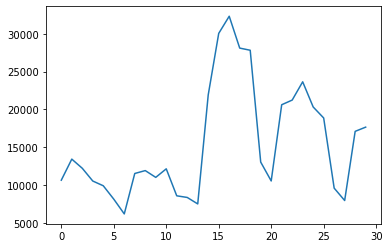

In [21]:
import matplotlib.pyplot as plt
x = list(range(len(int_data)))
y = int_data
plt.plot(x, y)

It matches the plot in website!
![](assets/Matched.png)

For the parameter `t`, it is related to the `uniqid` which I mentioned before. We can get `t` from [http://index.baidu.com/Interface/ptbk?uniqid={}](http://index.baidu.com/Interface/ptbk?uniqid={}), it returns data in `json` format in this structure:

```json
{
    "status": STATUS_CODE,
    "data": PARAM_T,
    ...
}
```

## Designing

1. Get `uniqid` and `data` through URL
2. Get `ptbk.json` using `uniqid`
3. Decrypt by `ptbk` and `data` to get the `index_data`

http://index.baidu.com/api/SearchApi/index?area=0&word=[[%7B"name":"基金","wordType":1%7D]]&startDate=2015-01-01&endDate=2021-01-20

http://index.baidu.com/Interface/ptbk?uniqid=d47d71dc7466160b2ddb78c46df5362d


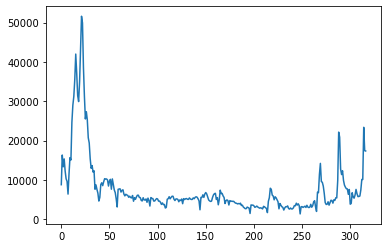

In [8]:
import requests
import sys
import time
import pandas as pd
import numpy as np
import datetime


class BaiduIndexScrapyer:
    
    def __init__(self, keyword, start, end, cookies):
        self.word_url = 'http://index.baidu.com/api/SearchApi/thumbnail?area=0&word={}'
        self.keyword = keyword
        self.start = start
        self.end = end
        self.cookies = cookies
    
    def decrypt(self, t, e):
        n = list(t)
        i = list(e)
        a = {}
        result = []
        ln = int(len(n) / 2)
        start = n[ln:]
        end = n[:ln]
        for j, k in zip(start, end):
            a.update({k: j})
        for j in e:
            result.append(a.get(j))
        return ''.join(result)


    def get_index_home(self, keyword):
        headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.90 Safari/537.36',
            'Cookie': self.cookies
        }
        word_url = f'http://index.baidu.com/api/SearchApi/thumbnail?area=0&word=[[%7B%22name%22:%22{keyword}%22,%22wordType%22:1%7D]]'
        resp = requests.get(word_url, headers=headers)
        j = resp.json()

        print(j)

        uniqid = j.get('data').get('uniqid')
        return get_ptbk(uniqid)


    def get_ptbk(self, uniqid):
        url = 'http://index.baidu.com/Interface/ptbk?uniqid={}'
        ptbk_headers = {
            'Accept': 'application/json, text/plain, */*',
            'Accept-Encoding': 'gzip, deflate',
            'Accept-Language': 'zh-CN,zh;q=0.9',
            'Cache-Control': 'no-cache',
            'Cookie': self.cookies,
            'DNT': '1',
            'Host': 'index.baidu.com',
            'Pragma': 'no-cache',
            'Proxy-Connection': 'keep-alive',
            'Referer': 'http://index.baidu.com/v2/index.html',
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.90 Safari/537.36',
            'X-Requested-With': 'XMLHttpRequest',
        }
        print(url.format(uniqid))
        resp = requests.get(url.format(uniqid), headers=ptbk_headers)

        # HTTP Response failed
        if resp.status_code != 200:
            print('Failed to get uniqid')
            sys.exit(1)

        return resp.json().get('data')


    def get_index_data(self, keyword, start, end):
        url = f'http://index.baidu.com/api/SugApi/sug?inputword[]={keyword}&area=0&startDate={start}&endDate={end}'
        word_param = f'[[%7B"name":"{keyword}","wordType":1%7D]]'
        url1 = f'http://index.baidu.com/api/SearchApi/index?area=0&word={word_param}&startDate={start}&endDate={end}'
        print(url1 + "\n")
        headers = {
            'Accept': 'application/json, text/plain, */*',
            'Accept-Encoding': 'gzip, deflate',
            'Accept-Language': 'zh-CN,zh;q=0.9',
            'Cache-Control': 'no-cache',
            'Cookie': self.cookies,
            'DNT': '1',
            'Host': 'index.baidu.com',
            'Pragma': 'no-cache',
            'Proxy-Connection': 'keep-alive',
            'Referer': 'http://index.baidu.com/v2/index.html',
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36',
            'X-Requested-With': 'XMLHttpRequest',
        }

        resp = requests.get(url1, headers=headers)

        # HTTP Response failed
        if resp.status_code != 200:
            print('Error happens when fetching index')
            sys.exit(1)

        data = resp.json().get('data').get('userIndexes')[0]
        uniqid = resp.json().get('data').get('uniqid')
        ptbk = self.get_ptbk(uniqid)
        all_data = data.get('all').get('data')
        result = self.decrypt(ptbk, all_data)
        result = result.split(',')
        return result

    def get(self):
        str_data = self.get_index_data(keyword=self.keyword, start=self.start, end=self.end)
        int_data = []
        for d in str_data:
            int_data.append(int(d))
        return int_data

    def plot(self, data):
        import matplotlib.pyplot as plt
        x = list(range(len(data)))
        y = data
        plt.plot(x, y)

if __name__ == '__main__':
    startDate = '2015-01-01'
    endDate = datetime.date.today()
    keyword = '基金'
    cookies = 'BDUSS=npzcndvZWxlYX5KMjg2bXpqOWdzUDQ2SE96Vkt2MlNMZjFaSVhEakpNY0lSeTlnRVFBQUFBJCQAAAAAAAAAAAEAAAANy6Vatv679db30uWBVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAi6B2AIugdgV; CHKFORREG=d653076750ed5b3ac7f12752f0cb663d; bdindexid=2s3g96u5kg5d0hit2esila5l80; Hm_lvt_d101ea4d2a5c67dab98251f0b5de24dc=1611123855,1611124055,1611125046,1611125162; Hm_lpvt_d101ea4d2a5c67dab98251f0b5de24dc=1611125913; __yjsv5_shitong=1.0_7_30c41c549108ec4a61f1658b1d80c3d142b4_300_1611125913587_202.86.179.90_c26b5af6; BAIDUID=9C7892480E03E397AA2C4A324AB1A841:FG=1; RT="z=1&dm=baidu.com&si=rgjbcrll45&ss=kk4ypmbo&sl=1m&tt=i1s2&bcn=https%3A%2F%2Ffclog.baidu.com%2Flog%2Fweirwood%3Ftype%3Dperf&ld=4jaj7&ul=4u4h4"'
    bis = BaiduIndexScrapyer(keyword, startDate, endDate, cookies)
    data = bis.get()
    bis.plot(data)

## References

- https://zhuanlan.zhihu.com/p/78634149
- https://zhuanlan.zhihu.com/p/147642620
- http://index.baidu.com/v2/index.html